In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 5000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
mod2_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
mod2_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
mod2_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
mod2_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
mod2_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
mod2_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

mod2_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
mod2_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
mod2_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

mod2_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
mod2_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
mod2_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [9]:
mod2_s1d1 = mod2_s1d1.X.toarray()
mod2_s1d2 = mod2_s1d2.X.toarray()
mod2_s1d3 = mod2_s1d3.X.toarray()
mod2_s2d1 = mod2_s2d1.X.toarray()
mod2_s2d4 = mod2_s2d4.X.toarray()
mod2_s2d5 = mod2_s2d5.X.toarray()

mod2_s3d1 = mod2_s3d1.X.toarray()
mod2_s3d6 = mod2_s3d6.X.toarray()
mod2_s3d7 = mod2_s3d7.X.toarray()

mod2_s4d1 = mod2_s4d1.X.toarray()
mod2_s4d8 = mod2_s4d8.X.toarray()
mod2_s4d9 = mod2_s4d9.X.toarray()

In [10]:
print(mod2_s1d1.shape)
print(mod2_s4d1.shape)

(4721, 134)
(334, 134)


In [11]:
start = time.perf_counter()

# mod1_train = pd.read_csv('RNA_gex.combined.csv')

# end = time.perf_counter()
# print(f'Loading data finished in {(end-start)/60} mins')

# mod1_train = mod1_train.transpose()
# mod1_train['batch'] = mod1_train.index.str[-4:]
# mod1_train = mod1_train.iloc[1:, :]
# mod1_train.reset_index(drop=True, inplace=True)
# mod1_train = mod1_train.drop(9941, axis=1)

In [12]:
# start = time.perf_counter()
# mod1_train.to_pickle("./mod1_train_RNA_featurs.pkl")
# end = time.perf_counter()
# print(f'Writing data finished in {(end-start)/60} mins')

In [13]:
start = time.perf_counter()
mod1_train = pd.read_pickle("./mod1_train_RNA_featurs.pkl")
end = time.perf_counter()
print(f'Loading data finished in {(end-start)/60} mins')

Loading data finished in 0.6549279073165962 mins


Batches:

Train: ['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']

Test: ['s4d1', 's4d8', 's4d9']

In [14]:
mod1_s1d1 = mod1_train[mod1_train['batch'] == 's1d1']
mod1_s1d2 = mod1_train[mod1_train['batch'] == 's1d2']
mod1_s1d3 = mod1_train[mod1_train['batch'] == 's1d3']
mod1_s2d1 = mod1_train[mod1_train['batch'] == 's2d1']
mod1_s2d4 = mod1_train[mod1_train['batch'] == 's2d4']
mod1_s2d5 = mod1_train[mod1_train['batch'] == 's2d5']
mod1_s3d1 = mod1_train[mod1_train['batch'] == 's3d1']
mod1_s3d6 = mod1_train[mod1_train['batch'] == 's3d6']
mod1_s3d7 = mod1_train[mod1_train['batch'] == 's3d7']

In [15]:
mod1_s4d1 = mod1_train[mod1_train['batch'] == 's4d1']
mod1_s4d8 = mod1_train[mod1_train['batch'] == 's4d8']
mod1_s4d9 = mod1_train[mod1_train['batch'] == 's4d9']

In [16]:
batch_s1d1 = mod1_s1d1["batch"]
batch_s1d2 = mod1_s1d2["batch"]
batch_s1d3 = mod1_s1d3["batch"]
batch_s2d1 = mod1_s2d1["batch"]
batch_s2d4 = mod1_s2d4["batch"]
batch_s2d5 = mod1_s2d5["batch"]

batch_s3d1 = mod1_s3d1["batch"]
batch_s3d6 = mod1_s3d6["batch"]
batch_s3d7 = mod1_s3d7["batch"]

batch_s4d1 = mod1_s4d1["batch"]
batch_s4d8 = mod1_s4d8["batch"]
batch_s4d9 = mod1_s4d9["batch"]

In [17]:
mod1_s1d1 = mod1_s1d1.drop('batch', axis=1)
mod1_s1d2 = mod1_s1d2.drop('batch', axis=1)
mod1_s1d3 = mod1_s1d3.drop('batch', axis=1)
mod1_s2d1 = mod1_s2d1.drop('batch', axis=1)
mod1_s2d4 = mod1_s2d4.drop('batch', axis=1)
mod1_s2d5 = mod1_s2d5.drop('batch', axis=1)

mod1_s3d1 = mod1_s3d1.drop('batch', axis=1)
mod1_s3d6 = mod1_s3d6.drop('batch', axis=1)
mod1_s3d7 = mod1_s3d7.drop('batch', axis=1)

mod1_s4d1 = mod1_s4d1.drop('batch', axis=1)
mod1_s4d8 = mod1_s4d8.drop('batch', axis=1)
mod1_s4d9 = mod1_s4d9.drop('batch', axis=1)

In [18]:
mod1_s1d1 = mod1_s1d1.to_numpy()
mod1_s1d2 = mod1_s1d2.to_numpy()
mod1_s1d3 = mod1_s1d3.to_numpy()
mod1_s2d1 = mod1_s2d1.to_numpy()
mod1_s2d4 = mod1_s2d4.to_numpy()
mod1_s2d5 = mod1_s2d5.to_numpy()

mod1_s3d1 = mod1_s3d1.to_numpy()
mod1_s3d6 = mod1_s3d6.to_numpy()
mod1_s3d7 = mod1_s3d7.to_numpy()

mod1_s4d1 = mod1_s4d1.to_numpy()
mod1_s4d8 = mod1_s4d8.to_numpy()
mod1_s4d9 = mod1_s4d9.to_numpy()

In [19]:
mod1_s1d1 = mod1_s1d1[:, :-1]
mod1_s1d2 = mod1_s1d2[:, :-1]
mod1_s1d3 = mod1_s1d3[:, :-1]
mod1_s2d1 = mod1_s2d1[:, :-1]
mod1_s2d4 = mod1_s2d4[:, :-1]
mod1_s2d5 = mod1_s2d5[:, :-1]

mod1_s3d1 = mod1_s3d1[:, :-1]
mod1_s3d6 = mod1_s3d6[:, :-1]
mod1_s3d7 = mod1_s3d7[:, :-1]

mod1_s4d1 = mod1_s4d1[:, :-1]
mod1_s4d8 = mod1_s4d8[:, :-1]
mod1_s4d9 = mod1_s4d9[:, :-1]

In [20]:
mod1_s1d1.shape

(4721, 9940)

In [21]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [22]:
train_input = [mod1_s1d1, mod1_s1d2, mod1_s1d3, mod1_s2d1, mod1_s2d4, mod1_s2d5]
train_output = [mod2_s1d1, mod2_s1d2, mod2_s1d3, mod2_s2d1, mod2_s2d4, mod2_s2d5]

val_input = [mod1_s3d1, mod1_s3d6, mod1_s3d7]
val_output = [mod2_s3d1, mod2_s3d6, mod2_s3d7]

test_input = [mod1_s4d1, mod1_s4d8, mod1_s4d9]
test_output = [mod2_s4d1, mod2_s4d8, mod2_s4d9]

In [23]:
train_input = train_input + val_input
train_output = train_output + val_output

In [24]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [25]:
train_input = np.reshape(train_input, (train_input.shape[0], 142, 70))
val_input = np.reshape(val_input, (val_input.shape[0], 142, 70))
test_input = np.reshape(test_input, (test_input.shape[0], 142, 70))

In [26]:
train_input = np.expand_dims(train_input, axis=(1))
val_input = np.expand_dims(val_input, axis=(1))
test_input = np.expand_dims(test_input, axis=(1))

In [27]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 1, 142, 70)
(28921, 1, 142, 70)
(1000, 1, 142, 70)


In [28]:
print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

(66175, 134)
(28921, 134)
(1000, 134)


In [29]:
train_input = np.float32(train_input)
train_output = np.float32(train_output)
val_input = np.float32(val_input)
val_output = np.float32(val_output)
test_input = np.float32(test_input)
test_output = np.float32(test_output)

In [30]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [31]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [32]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [33]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [34]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [35]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [36]:
batch_train = batch_train + batch_val

In [37]:
train_output = train_output[:, 0:pred_num]
train_output.shape

val_output = val_output[:, 0:pred_num]
val_output.shape

test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [38]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [39]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [40]:
# auto-encoder model
# base model
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        self.conv_1 = nn.Conv2d(1, 2, 3)
        self.maxpool = nn.MaxPool2d(5)
        self.conv_2 = nn.Conv2d(2, 4, 3)
        self.dropout = nn.Dropout(0.15)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(728, pred_num)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # x = self.conv_2(x)
        # x = self.relu(x)
        # x = self.maxpool(x)
        x = torch.flatten(x, 1)
        output = self.linear(x)
        
        return output.float()

In [41]:
PATH = 'CNN_No_norm_model_RNA_pro'

In [42]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 2000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

In [43]:
num_epochs = 20000
learning_rate = 0.0001
loss_fn = F.mse_loss
batch_size = 5000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = CNN_model()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)

Epoch  0 Train_loss:  0.3468707  Validation_loss:  0.27457485  Test_loss:  0.34501165


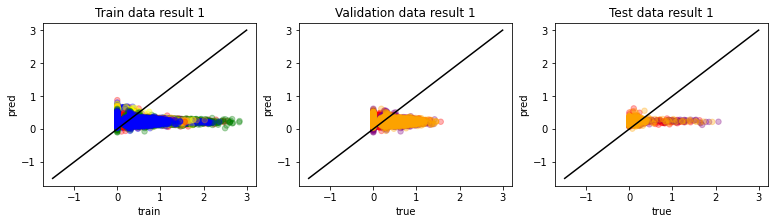

Epoch  100 Train_loss:  0.26385128  Validation_loss:  0.21417487  Test_loss:  0.28344113
Epoch  200 Train_loss:  0.2594094  Validation_loss:  0.21249868  Test_loss:  0.2769585
Epoch  300 Train_loss:  0.25743225  Validation_loss:  0.21098274  Test_loss:  0.27438402
Epoch  400 Train_loss:  0.25604004  Validation_loss:  0.2099149  Test_loss:  0.27255926
Epoch  500 Train_loss:  0.2550613  Validation_loss:  0.2090704  Test_loss:  0.271438
Epoch  600 Train_loss:  0.25429752  Validation_loss:  0.20838389  Test_loss:  0.27055168
Epoch  700 Train_loss:  0.25348997  Validation_loss:  0.20791847  Test_loss:  0.2692997
Epoch  800 Train_loss:  0.25304148  Validation_loss:  0.2074117  Test_loss:  0.26895866
Epoch  900 Train_loss:  0.2526044  Validation_loss:  0.20701145  Test_loss:  0.2684593
Epoch  1000 Train_loss:  0.25198358  Validation_loss:  0.2068029  Test_loss:  0.26727763
Epoch  1100 Train_loss:  0.25171125  Validation_loss:  0.20647158  Test_loss:  0.26708955
Epoch  1200 Train_loss:  0.2513

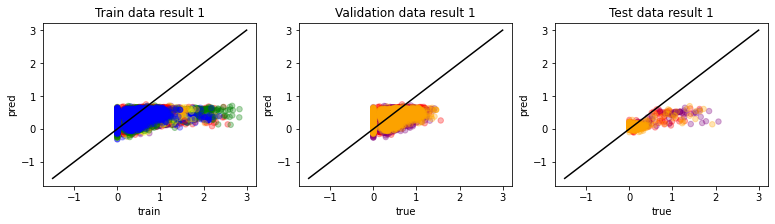

Epoch  2100 Train_loss:  0.24943814  Validation_loss:  0.20492217  Test_loss:  0.26389265
Epoch  2200 Train_loss:  0.24922511  Validation_loss:  0.20488787  Test_loss:  0.26345566
Epoch  2300 Train_loss:  0.24902458  Validation_loss:  0.20486338  Test_loss:  0.26306567
Epoch  2400 Train_loss:  0.24893829  Validation_loss:  0.20477866  Test_loss:  0.26300958
Epoch  2500 Train_loss:  0.24880935  Validation_loss:  0.20472871  Test_loss:  0.26281768
Epoch  2600 Train_loss:  0.24885932  Validation_loss:  0.20461258  Test_loss:  0.26310515
Epoch  2700 Train_loss:  0.24855791  Validation_loss:  0.20464408  Test_loss:  0.26239988
Epoch  2800 Train_loss:  0.24858706  Validation_loss:  0.20454271  Test_loss:  0.2626281
Epoch  2900 Train_loss:  0.24847102  Validation_loss:  0.20452379  Test_loss:  0.26242486
Epoch  3000 Train_loss:  0.24846512  Validation_loss:  0.20444982  Test_loss:  0.2625812
Epoch  3100 Train_loss:  0.24828738  Validation_loss:  0.20444845  Test_loss:  0.26215506
Epoch  3200 

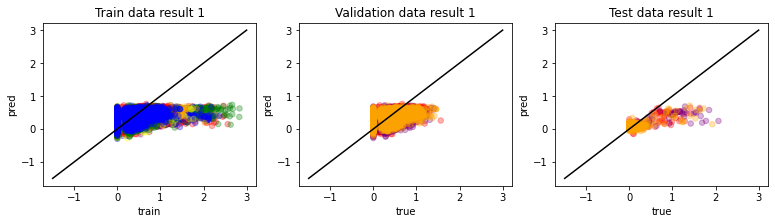

Epoch  4100 Train_loss:  0.24765347  Validation_loss:  0.20413633  Test_loss:  0.26140332
Epoch  4200 Train_loss:  0.24760014  Validation_loss:  0.20412366  Test_loss:  0.26135933
Epoch  4300 Train_loss:  0.24752071  Validation_loss:  0.20411612  Test_loss:  0.26123628
Epoch  4400 Train_loss:  0.24745373  Validation_loss:  0.2041138  Test_loss:  0.2611647
Epoch  4500 Train_loss:  0.24739996  Validation_loss:  0.20408666  Test_loss:  0.26108724
Epoch  4600 Train_loss:  0.24746828  Validation_loss:  0.20404063  Test_loss:  0.2614267
Epoch  4700 Train_loss:  0.24738503  Validation_loss:  0.20403662  Test_loss:  0.26128104
Epoch  4800 Train_loss:  0.2471682  Validation_loss:  0.2040849  Test_loss:  0.2607509
Epoch  4900 Train_loss:  0.2472745  Validation_loss:  0.20401202  Test_loss:  0.26118192
Epoch  5000 Train_loss:  0.24709623  Validation_loss:  0.20404226  Test_loss:  0.2608096
Epoch  5100 Train_loss:  0.24712011  Validation_loss:  0.2040086  Test_loss:  0.2609881
Epoch  5200 Train_lo

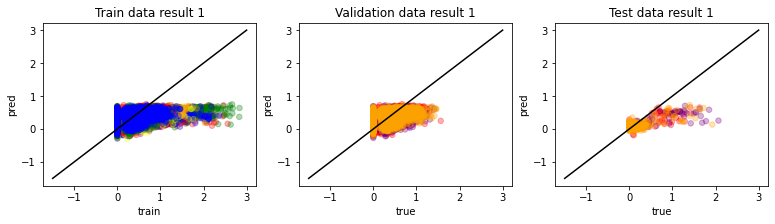

Epoch  6100 Train_loss:  0.24652898  Validation_loss:  0.20393747  Test_loss:  0.26068312
Epoch  6200 Train_loss:  0.24643393  Validation_loss:  0.20396626  Test_loss:  0.260564
Epoch  6300 Train_loss:  0.24628627  Validation_loss:  0.20400944  Test_loss:  0.26035693
Epoch  6400 Train_loss:  0.24626106  Validation_loss:  0.20399591  Test_loss:  0.26048052
Epoch  6500 Train_loss:  0.24618562  Validation_loss:  0.20400444  Test_loss:  0.26048043
Epoch  6600 Train_loss:  0.24605419  Validation_loss:  0.20403922  Test_loss:  0.26031637
Epoch  6700 Train_loss:  0.24588498  Validation_loss:  0.20409667  Test_loss:  0.26003325
Epoch  6800 Train_loss:  0.24582617  Validation_loss:  0.20409742  Test_loss:  0.2601143
Epoch  6900 Train_loss:  0.24576356  Validation_loss:  0.20409985  Test_loss:  0.260218
Epoch  7000 Train_loss:  0.24558234  Validation_loss:  0.20417103  Test_loss:  0.25999656
Epoch  7100 Train_loss:  0.24543999  Validation_loss:  0.20421031  Test_loss:  0.25985172
Epoch  7200 Tra

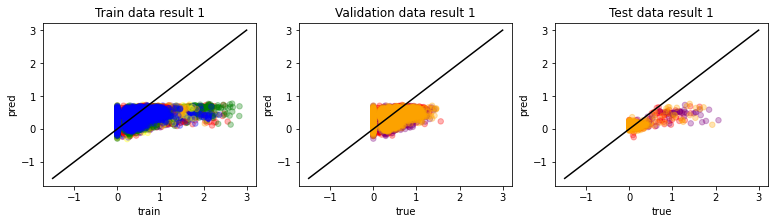

Epoch  8100 Train_loss:  0.24370262  Validation_loss:  0.20481554  Test_loss:  0.2577235
Epoch  8200 Train_loss:  0.24357851  Validation_loss:  0.20485756  Test_loss:  0.25764555
Epoch  8300 Train_loss:  0.24343926  Validation_loss:  0.20489739  Test_loss:  0.257497
Epoch  8400 Train_loss:  0.2432303  Validation_loss:  0.20494933  Test_loss:  0.25710234
Epoch  8500 Train_loss:  0.24309215  Validation_loss:  0.20498496  Test_loss:  0.2569622
Epoch  8600 Train_loss:  0.24293175  Validation_loss:  0.20501764  Test_loss:  0.25674376
Epoch  8700 Train_loss:  0.24275838  Validation_loss:  0.20507178  Test_loss:  0.2564466
Epoch  8800 Train_loss:  0.24261317  Validation_loss:  0.20511141  Test_loss:  0.25633043
Epoch  8900 Train_loss:  0.24238387  Validation_loss:  0.20517977  Test_loss:  0.25585794
Epoch  9000 Train_loss:  0.24229114  Validation_loss:  0.2051574  Test_loss:  0.2558212
Epoch  9100 Train_loss:  0.24211599  Validation_loss:  0.20520607  Test_loss:  0.25554526
Epoch  9200 Train_

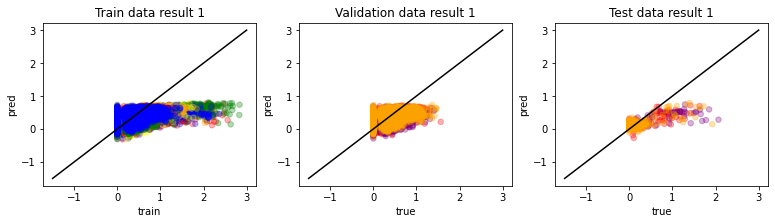

Epoch  10100 Train_loss:  0.24088418  Validation_loss:  0.2052556  Test_loss:  0.25434333
Epoch  10200 Train_loss:  0.24078192  Validation_loss:  0.20524797  Test_loss:  0.25431627
Epoch  10300 Train_loss:  0.24069232  Validation_loss:  0.20522858  Test_loss:  0.25430942
Epoch  10400 Train_loss:  0.2405386  Validation_loss:  0.20523232  Test_loss:  0.2540473
Epoch  10500 Train_loss:  0.24042119  Validation_loss:  0.20523845  Test_loss:  0.25396094
Epoch  10600 Train_loss:  0.24035263  Validation_loss:  0.20520961  Test_loss:  0.25405356
Epoch  10700 Train_loss:  0.24020524  Validation_loss:  0.20522213  Test_loss:  0.2538077
Epoch  10800 Train_loss:  0.24015991  Validation_loss:  0.20517781  Test_loss:  0.25394574
Epoch  10900 Train_loss:  0.23999666  Validation_loss:  0.20519714  Test_loss:  0.25367102
Epoch  11000 Train_loss:  0.23992358  Validation_loss:  0.20516148  Test_loss:  0.25373033
Epoch  11100 Train_loss:  0.23978528  Validation_loss:  0.2051652  Test_loss:  0.25354943
Epoc

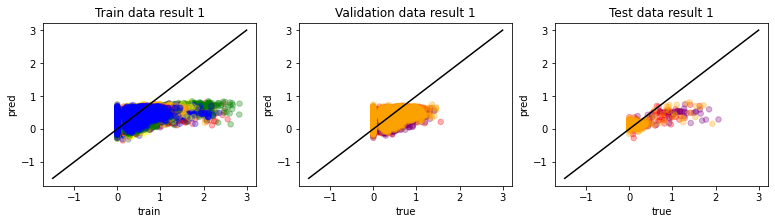

Epoch  12100 Train_loss:  0.23888221  Validation_loss:  0.20498894  Test_loss:  0.25326806
Epoch  12200 Train_loss:  0.23883057  Validation_loss:  0.20494111  Test_loss:  0.253389
Epoch  12300 Train_loss:  0.23865557  Validation_loss:  0.20499972  Test_loss:  0.25301042
Epoch  12400 Train_loss:  0.23858933  Validation_loss:  0.20496872  Test_loss:  0.25306565
Epoch  12500 Train_loss:  0.23854008  Validation_loss:  0.20492259  Test_loss:  0.25322127
Epoch  12600 Train_loss:  0.23843712  Validation_loss:  0.20492983  Test_loss:  0.25308526
Epoch  12700 Train_loss:  0.23836218  Validation_loss:  0.20490852  Test_loss:  0.25311232
Epoch  12800 Train_loss:  0.23825988  Validation_loss:  0.2049104  Test_loss:  0.25301868
Epoch  12900 Train_loss:  0.23821284  Validation_loss:  0.2048667  Test_loss:  0.25311106
Epoch  13000 Train_loss:  0.23808952  Validation_loss:  0.20489736  Test_loss:  0.2528875
Epoch  13100 Train_loss:  0.23807056  Validation_loss:  0.20480679  Test_loss:  0.25312045
Epoc

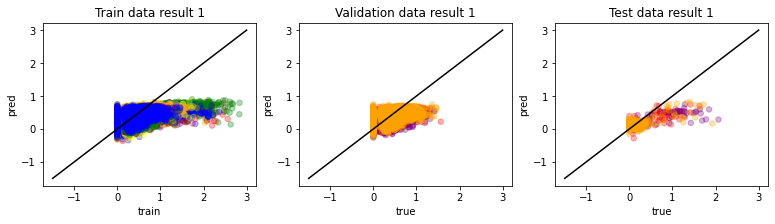

Epoch  14100 Train_loss:  0.23731723  Validation_loss:  0.20473124  Test_loss:  0.25295454
Epoch  14200 Train_loss:  0.23724534  Validation_loss:  0.20472538  Test_loss:  0.25292572
Epoch  14300 Train_loss:  0.23718597  Validation_loss:  0.20471202  Test_loss:  0.25295305
Epoch  14400 Train_loss:  0.23711124  Validation_loss:  0.20471188  Test_loss:  0.2528784
Epoch  14500 Train_loss:  0.23705323  Validation_loss:  0.20469536  Test_loss:  0.25296506
Epoch  14600 Train_loss:  0.23696281  Validation_loss:  0.20472546  Test_loss:  0.2527905
Epoch  14700 Train_loss:  0.23693375  Validation_loss:  0.20465627  Test_loss:  0.25300282
Epoch  14800 Train_loss:  0.2368661  Validation_loss:  0.20465696  Test_loss:  0.25293684
Epoch  14900 Train_loss:  0.2367795  Validation_loss:  0.20469417  Test_loss:  0.25283378
Epoch  15000 Train_loss:  0.23673369  Validation_loss:  0.20465621  Test_loss:  0.25289726
Epoch  15100 Train_loss:  0.23667006  Validation_loss:  0.20465112  Test_loss:  0.25289062
Epo

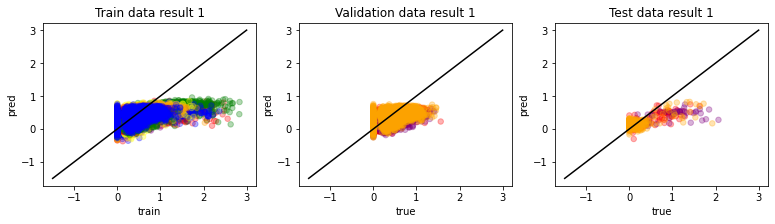

Epoch  16100 Train_loss:  0.23611137  Validation_loss:  0.20459722  Test_loss:  0.2529304
Epoch  16200 Train_loss:  0.2360386  Validation_loss:  0.20462899  Test_loss:  0.25283468
Epoch  16300 Train_loss:  0.23601691  Validation_loss:  0.20457427  Test_loss:  0.2529739
Epoch  16400 Train_loss:  0.2359329  Validation_loss:  0.20465854  Test_loss:  0.25273788
Epoch  16500 Train_loss:  0.235911  Validation_loss:  0.20456357  Test_loss:  0.2530241
Epoch  16600 Train_loss:  0.23584604  Validation_loss:  0.20460989  Test_loss:  0.2528703
Epoch  16700 Train_loss:  0.23580882  Validation_loss:  0.20457618  Test_loss:  0.25294352
Epoch  16800 Train_loss:  0.23575942  Validation_loss:  0.20456377  Test_loss:  0.25297645
Epoch  16900 Train_loss:  0.23571566  Validation_loss:  0.20458367  Test_loss:  0.25289762
Epoch  17000 Train_loss:  0.23566183  Validation_loss:  0.20454867  Test_loss:  0.25301433
Epoch  17100 Train_loss:  0.23561133  Validation_loss:  0.2045555  Test_loss:  0.25296497
Epoch  1

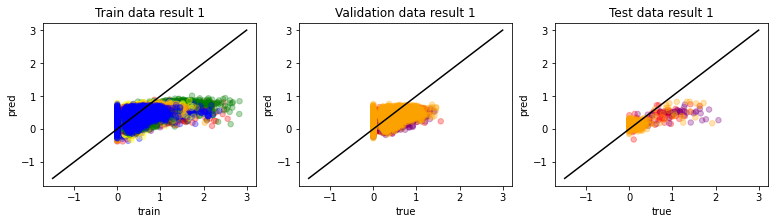

Epoch  18100 Train_loss:  0.23517132  Validation_loss:  0.20454583  Test_loss:  0.2530304
Epoch  18200 Train_loss:  0.2351393  Validation_loss:  0.20453368  Test_loss:  0.25309312
Epoch  18300 Train_loss:  0.23510483  Validation_loss:  0.20449845  Test_loss:  0.2531874
Epoch  18400 Train_loss:  0.23506297  Validation_loss:  0.20451191  Test_loss:  0.2531437
Epoch  18500 Train_loss:  0.23503599  Validation_loss:  0.20448567  Test_loss:  0.25322443
Epoch  18600 Train_loss:  0.23499878  Validation_loss:  0.20451358  Test_loss:  0.2531473
Epoch  18700 Train_loss:  0.2349588  Validation_loss:  0.2045457  Test_loss:  0.25309238
Epoch  18800 Train_loss:  0.23491561  Validation_loss:  0.20450966  Test_loss:  0.2531797
Epoch  18900 Train_loss:  0.23487705  Validation_loss:  0.2045591  Test_loss:  0.25307822
Epoch  19000 Train_loss:  0.2348652  Validation_loss:  0.20448902  Test_loss:  0.25327912
Epoch  19100 Train_loss:  0.23482932  Validation_loss:  0.2045208  Test_loss:  0.25320688
Epoch  192

In [44]:
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.24663857  Validation_loss:  0.20393199  Test_loss:  0.26064014


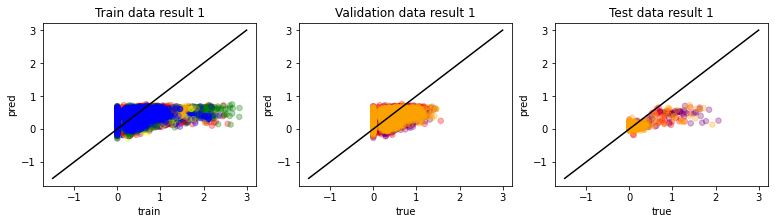

Epoch  100 Train_loss:  0.24653108  Validation_loss:  0.20397288  Test_loss:  0.26048455
Epoch  200 Train_loss:  0.24649723  Validation_loss:  0.2039608  Test_loss:  0.2606098
Epoch  300 Train_loss:  0.24644747  Validation_loss:  0.20395869  Test_loss:  0.26061806
Epoch  400 Train_loss:  0.24630854  Validation_loss:  0.2039936  Test_loss:  0.26039463
Epoch  500 Train_loss:  0.24624403  Validation_loss:  0.20400584  Test_loss:  0.26041865
Epoch  600 Train_loss:  0.24618639  Validation_loss:  0.20400664  Test_loss:  0.26048422
Epoch  700 Train_loss:  0.24598734  Validation_loss:  0.20406519  Test_loss:  0.26009554
Epoch  800 Train_loss:  0.24602672  Validation_loss:  0.20402668  Test_loss:  0.2604375
Epoch  900 Train_loss:  0.24592057  Validation_loss:  0.20405252  Test_loss:  0.26038453
Epoch  1000 Train_loss:  0.24567117  Validation_loss:  0.20414665  Test_loss:  0.25993362
Epoch  1100 Train_loss:  0.24558012  Validation_loss:  0.20416944  Test_loss:  0.25998077
Epoch  1200 Train_loss:

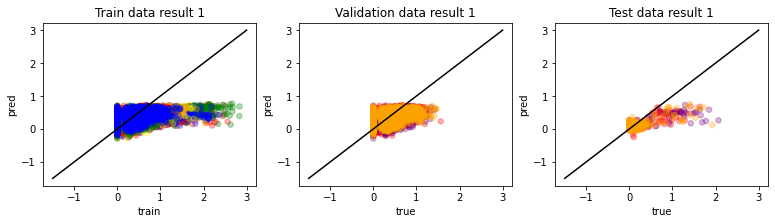

Epoch  2100 Train_loss:  0.2439815  Validation_loss:  0.20467862  Test_loss:  0.2582454
Epoch  2200 Train_loss:  0.24372801  Validation_loss:  0.20478842  Test_loss:  0.25778693
Epoch  2300 Train_loss:  0.24352156  Validation_loss:  0.2048717  Test_loss:  0.2574269
Epoch  2400 Train_loss:  0.24339142  Validation_loss:  0.20490515  Test_loss:  0.25730792
Epoch  2500 Train_loss:  0.24322289  Validation_loss:  0.20495749  Test_loss:  0.2570643
Epoch  2600 Train_loss:  0.24315998  Validation_loss:  0.20496976  Test_loss:  0.25715613
Epoch  2700 Train_loss:  0.2428692  Validation_loss:  0.20506257  Test_loss:  0.25654662
Epoch  2800 Train_loss:  0.24277957  Validation_loss:  0.20507309  Test_loss:  0.25652632
Epoch  2900 Train_loss:  0.24259144  Validation_loss:  0.20513237  Test_loss:  0.25626057
Epoch  3000 Train_loss:  0.2425197  Validation_loss:  0.20512705  Test_loss:  0.256281
Epoch  3100 Train_loss:  0.24228992  Validation_loss:  0.20518184  Test_loss:  0.25582328
Epoch  3200 Train_l

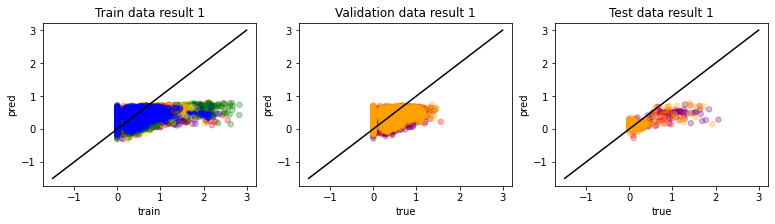

Epoch  4100 Train_loss:  0.24102123  Validation_loss:  0.20522903  Test_loss:  0.25446245
Epoch  4200 Train_loss:  0.24089989  Validation_loss:  0.20524201  Test_loss:  0.25439575
Epoch  4300 Train_loss:  0.24078164  Validation_loss:  0.20524342  Test_loss:  0.25429106
Epoch  4400 Train_loss:  0.24066326  Validation_loss:  0.2052481  Test_loss:  0.25417468
Epoch  4500 Train_loss:  0.24055047  Validation_loss:  0.20523165  Test_loss:  0.25407273
Epoch  4600 Train_loss:  0.24047692  Validation_loss:  0.20522171  Test_loss:  0.2541501
Epoch  4700 Train_loss:  0.24036181  Validation_loss:  0.20521405  Test_loss:  0.2540409
Epoch  4800 Train_loss:  0.2401665  Validation_loss:  0.20524825  Test_loss:  0.25363997
Epoch  4900 Train_loss:  0.24013034  Validation_loss:  0.20520282  Test_loss:  0.25386137
Epoch  5000 Train_loss:  0.239974  Validation_loss:  0.20520459  Test_loss:  0.25361323
Epoch  5100 Train_loss:  0.23990299  Validation_loss:  0.20517917  Test_loss:  0.25363138
Epoch  5200 Trai

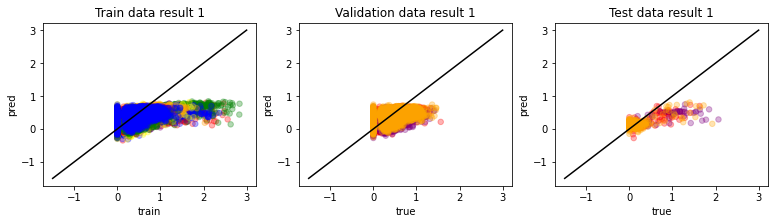

Epoch  6100 Train_loss:  0.23897254  Validation_loss:  0.2049962  Test_loss:  0.25331464
Epoch  6200 Train_loss:  0.23885895  Validation_loss:  0.2050066  Test_loss:  0.2531873
Epoch  6300 Train_loss:  0.23875873  Validation_loss:  0.2049998  Test_loss:  0.25311533
Epoch  6400 Train_loss:  0.23868169  Validation_loss:  0.20497747  Test_loss:  0.2531229
Epoch  6500 Train_loss:  0.23860523  Validation_loss:  0.20495592  Test_loss:  0.2531467
Epoch  6600 Train_loss:  0.23852414  Validation_loss:  0.20494382  Test_loss:  0.25310177
Epoch  6700 Train_loss:  0.23841982  Validation_loss:  0.20495167  Test_loss:  0.25300816
Epoch  6800 Train_loss:  0.23835796  Validation_loss:  0.20490377  Test_loss:  0.25307527
Epoch  6900 Train_loss:  0.23830105  Validation_loss:  0.20487271  Test_loss:  0.2531288
Epoch  7000 Train_loss:  0.23820262  Validation_loss:  0.20488025  Test_loss:  0.2530228
Epoch  7100 Train_loss:  0.2381244  Validation_loss:  0.20486948  Test_loss:  0.25299177
Epoch  7200 Train_l

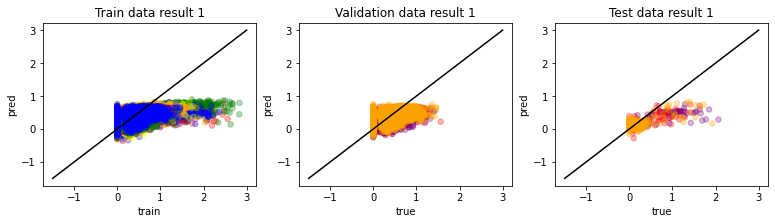

Epoch  8100 Train_loss:  0.23736367  Validation_loss:  0.20477271  Test_loss:  0.25283948
Epoch  8200 Train_loss:  0.23731102  Validation_loss:  0.20474567  Test_loss:  0.25293362
Epoch  8300 Train_loss:  0.23724973  Validation_loss:  0.20473057  Test_loss:  0.25294828
Epoch  8400 Train_loss:  0.23717263  Validation_loss:  0.2047273  Test_loss:  0.25285846
Epoch  8500 Train_loss:  0.23712172  Validation_loss:  0.20469669  Test_loss:  0.25295877
Epoch  8600 Train_loss:  0.23705886  Validation_loss:  0.20468718  Test_loss:  0.25293317
Epoch  8700 Train_loss:  0.23698501  Validation_loss:  0.20469749  Test_loss:  0.2528897
Epoch  8800 Train_loss:  0.23692632  Validation_loss:  0.20467663  Test_loss:  0.25291952
Epoch  8900 Train_loss:  0.23682828  Validation_loss:  0.2047221  Test_loss:  0.2527558
Epoch  9000 Train_loss:  0.23679341  Validation_loss:  0.20467223  Test_loss:  0.25285342
Epoch  9100 Train_loss:  0.23671433  Validation_loss:  0.20470214  Test_loss:  0.25278282
Epoch  9200 Tr

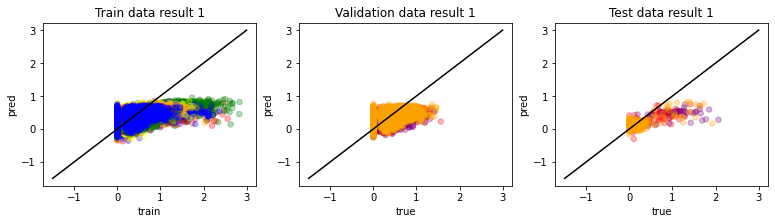

Epoch  10100 Train_loss:  0.23615372  Validation_loss:  0.20461987  Test_loss:  0.25289664
Epoch  10200 Train_loss:  0.23610413  Validation_loss:  0.20459479  Test_loss:  0.25292522
Epoch  10300 Train_loss:  0.2360599  Validation_loss:  0.20457797  Test_loss:  0.25297815
Epoch  10400 Train_loss:  0.23601253  Validation_loss:  0.2045958  Test_loss:  0.2528904
Epoch  10500 Train_loss:  0.23594847  Validation_loss:  0.20460027  Test_loss:  0.25288525
Epoch  10600 Train_loss:  0.23591104  Validation_loss:  0.20456505  Test_loss:  0.25300664
Epoch  10700 Train_loss:  0.23585145  Validation_loss:  0.20459163  Test_loss:  0.2529187
Epoch  10800 Train_loss:  0.23581727  Validation_loss:  0.2045492  Test_loss:  0.25306702
Epoch  10900 Train_loss:  0.23575081  Validation_loss:  0.2045964  Test_loss:  0.2528922
Epoch  11000 Train_loss:  0.23571105  Validation_loss:  0.2045567  Test_loss:  0.25299004
Epoch  11100 Train_loss:  0.23565707  Validation_loss:  0.20457223  Test_loss:  0.2529226
Epoch  1

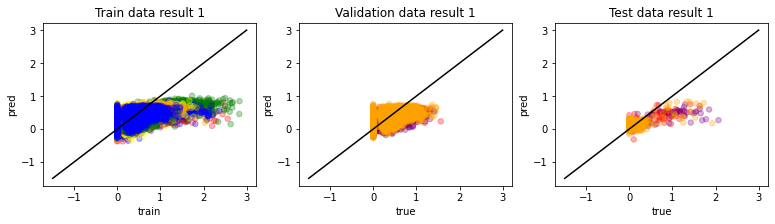

Epoch  12100 Train_loss:  0.23522475  Validation_loss:  0.20449455  Test_loss:  0.25315103
Epoch  12200 Train_loss:  0.23519892  Validation_loss:  0.20446499  Test_loss:  0.25325263
Epoch  12300 Train_loss:  0.23513153  Validation_loss:  0.20455906  Test_loss:  0.2529947
Epoch  12400 Train_loss:  0.23510528  Validation_loss:  0.20452163  Test_loss:  0.2530982
Epoch  12500 Train_loss:  0.23506354  Validation_loss:  0.20448516  Test_loss:  0.25322938
Epoch  12600 Train_loss:  0.23502399  Validation_loss:  0.20452127  Test_loss:  0.2531392
Epoch  12700 Train_loss:  0.23498976  Validation_loss:  0.2044987  Test_loss:  0.25322154
Epoch  12800 Train_loss:  0.23494579  Validation_loss:  0.20451833  Test_loss:  0.25317085
Epoch  12900 Train_loss:  0.23492774  Validation_loss:  0.20448728  Test_loss:  0.25325948
Epoch  13000 Train_loss:  0.23488615  Validation_loss:  0.20454454  Test_loss:  0.25311604
Epoch  13100 Train_loss:  0.23487392  Validation_loss:  0.20446075  Test_loss:  0.25332186
Epo

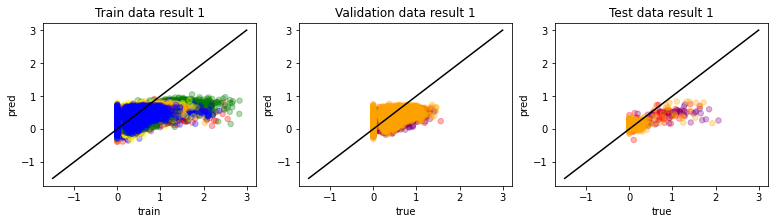

Epoch  14100 Train_loss:  0.23454972  Validation_loss:  0.2044958  Test_loss:  0.25339845
Epoch  14200 Train_loss:  0.23451877  Validation_loss:  0.20448875  Test_loss:  0.25340787
Epoch  14300 Train_loss:  0.23450492  Validation_loss:  0.20449103  Test_loss:  0.25344664
Epoch  14400 Train_loss:  0.23448086  Validation_loss:  0.20451279  Test_loss:  0.25339222
Epoch  14500 Train_loss:  0.2344449  Validation_loss:  0.20449243  Test_loss:  0.2534641
Epoch  14600 Train_loss:  0.23442082  Validation_loss:  0.20453762  Test_loss:  0.25334033
Epoch  14700 Train_loss:  0.23440067  Validation_loss:  0.20446998  Test_loss:  0.25350812
Epoch  14800 Train_loss:  0.2343778  Validation_loss:  0.2044878  Test_loss:  0.25347364
Epoch  14900 Train_loss:  0.23435043  Validation_loss:  0.20453343  Test_loss:  0.25339824
Epoch  15000 Train_loss:  0.23433009  Validation_loss:  0.20450468  Test_loss:  0.25346535
Epoch  15100 Train_loss:  0.23430093  Validation_loss:  0.20450665  Test_loss:  0.25346082
Epoc

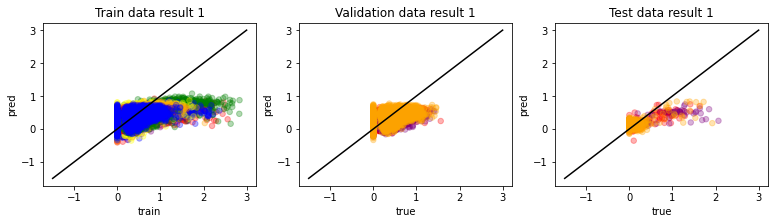

Epoch  16100 Train_loss:  0.23408209  Validation_loss:  0.20453659  Test_loss:  0.253536
Epoch  16200 Train_loss:  0.23405851  Validation_loss:  0.20459248  Test_loss:  0.25343975
Epoch  16300 Train_loss:  0.23404992  Validation_loss:  0.20453238  Test_loss:  0.25357938
Epoch  16400 Train_loss:  0.23403218  Validation_loss:  0.20463993  Test_loss:  0.25335562
Epoch  16500 Train_loss:  0.23400205  Validation_loss:  0.20454  Test_loss:  0.25357172
Epoch  16600 Train_loss:  0.23399144  Validation_loss:  0.20460552  Test_loss:  0.25347304
Epoch  16700 Train_loss:  0.23397425  Validation_loss:  0.20456822  Test_loss:  0.25353843
Epoch  16800 Train_loss:  0.23394552  Validation_loss:  0.20455709  Test_loss:  0.2535524
Epoch  16900 Train_loss:  0.23394713  Validation_loss:  0.20460449  Test_loss:  0.2534807
Epoch  17000 Train_loss:  0.2338984  Validation_loss:  0.20454212  Test_loss:  0.25358695
Epoch  17100 Train_loss:  0.23388545  Validation_loss:  0.20457423  Test_loss:  0.2535239
Epoch  1

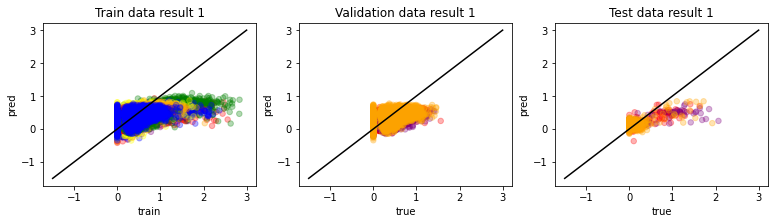

Epoch  18100 Train_loss:  0.23371312  Validation_loss:  0.20460032  Test_loss:  0.2535126
Epoch  18200 Train_loss:  0.23369806  Validation_loss:  0.20458296  Test_loss:  0.25356558
Epoch  18300 Train_loss:  0.23367429  Validation_loss:  0.2045535  Test_loss:  0.25361952
Epoch  18400 Train_loss:  0.23365839  Validation_loss:  0.2045686  Test_loss:  0.25358856
Epoch  18500 Train_loss:  0.23364484  Validation_loss:  0.20454913  Test_loss:  0.25363478
Epoch  18600 Train_loss:  0.23364049  Validation_loss:  0.20458846  Test_loss:  0.25354433
Epoch  18700 Train_loss:  0.23363036  Validation_loss:  0.20462719  Test_loss:  0.25349984
Epoch  18800 Train_loss:  0.23359296  Validation_loss:  0.20458767  Test_loss:  0.25356138
Epoch  18900 Train_loss:  0.23358542  Validation_loss:  0.20464292  Test_loss:  0.25345692
Epoch  19000 Train_loss:  0.23357458  Validation_loss:  0.20456062  Test_loss:  0.25362942
Epoch  19100 Train_loss:  0.23356755  Validation_loss:  0.20460854  Test_loss:  0.253544
Epoc

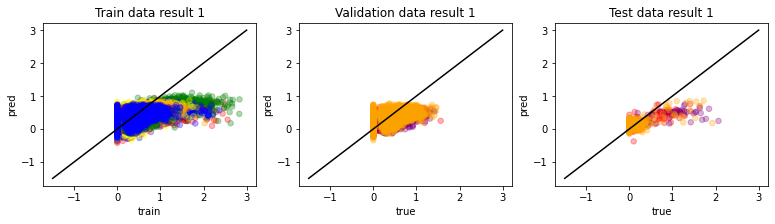

Epoch  20100 Train_loss:  0.23343563  Validation_loss:  0.20461379  Test_loss:  0.2535805
Epoch  20200 Train_loss:  0.23342457  Validation_loss:  0.20466648  Test_loss:  0.2535043
Epoch  20300 Train_loss:  0.23340459  Validation_loss:  0.20465566  Test_loss:  0.25351745
Epoch  20400 Train_loss:  0.23337819  Validation_loss:  0.20462209  Test_loss:  0.2536084
Epoch  20500 Train_loss:  0.23336989  Validation_loss:  0.20464048  Test_loss:  0.25359613
Epoch  20600 Train_loss:  0.23335332  Validation_loss:  0.20466918  Test_loss:  0.253525
Epoch  20700 Train_loss:  0.23337182  Validation_loss:  0.20468433  Test_loss:  0.25354618
Epoch  20800 Train_loss:  0.2333511  Validation_loss:  0.2046913  Test_loss:  0.25350666
Epoch  20900 Train_loss:  0.23333193  Validation_loss:  0.2046915  Test_loss:  0.25352445
Epoch  21000 Train_loss:  0.23331738  Validation_loss:  0.2046767  Test_loss:  0.25357196
Epoch  21100 Train_loss:  0.23329851  Validation_loss:  0.20459603  Test_loss:  0.253716
Epoch  212

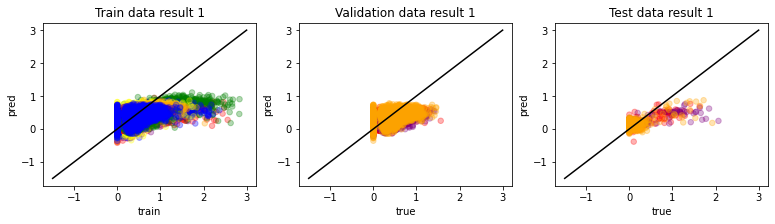

Epoch  22100 Train_loss:  0.23317388  Validation_loss:  0.20469627  Test_loss:  0.25357237
Epoch  22200 Train_loss:  0.2331688  Validation_loss:  0.20474157  Test_loss:  0.25352603
Epoch  22300 Train_loss:  0.23315708  Validation_loss:  0.2047138  Test_loss:  0.2535527
Epoch  22400 Train_loss:  0.23312855  Validation_loss:  0.20466284  Test_loss:  0.2536439
Epoch  22500 Train_loss:  0.23311228  Validation_loss:  0.20465064  Test_loss:  0.25367844
Epoch  22600 Train_loss:  0.23307864  Validation_loss:  0.20472255  Test_loss:  0.25352374
Epoch  22700 Train_loss:  0.23307265  Validation_loss:  0.2046691  Test_loss:  0.25363898
Epoch  22800 Train_loss:  0.23306394  Validation_loss:  0.20464778  Test_loss:  0.2536777
Epoch  22900 Train_loss:  0.23305976  Validation_loss:  0.20469299  Test_loss:  0.25360876
Epoch  23000 Train_loss:  0.23305123  Validation_loss:  0.20473666  Test_loss:  0.2535309
Epoch  23100 Train_loss:  0.23304239  Validation_loss:  0.2047553  Test_loss:  0.25350496
Epoch  

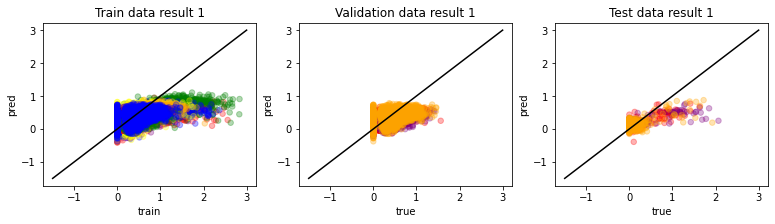

Epoch  24100 Train_loss:  0.23286977  Validation_loss:  0.2047008  Test_loss:  0.25356773
Epoch  24200 Train_loss:  0.232858  Validation_loss:  0.20476474  Test_loss:  0.25344118
Epoch  24300 Train_loss:  0.23284914  Validation_loss:  0.20475416  Test_loss:  0.25348622
Epoch  24400 Train_loss:  0.23281237  Validation_loss:  0.20475823  Test_loss:  0.25344884
Epoch  24500 Train_loss:  0.23282379  Validation_loss:  0.20474485  Test_loss:  0.2534923
Epoch  24600 Train_loss:  0.23279768  Validation_loss:  0.20470934  Test_loss:  0.25353652
Epoch  24700 Train_loss:  0.23278986  Validation_loss:  0.20476922  Test_loss:  0.2534218
Epoch  24800 Train_loss:  0.23275407  Validation_loss:  0.20475172  Test_loss:  0.25340068
Epoch  24900 Train_loss:  0.23276038  Validation_loss:  0.20480037  Test_loss:  0.25332102
Epoch  25000 Train_loss:  0.23273392  Validation_loss:  0.20482758  Test_loss:  0.25325528
Epoch  25100 Train_loss:  0.23273297  Validation_loss:  0.20480622  Test_loss:  0.2533126
Epoch

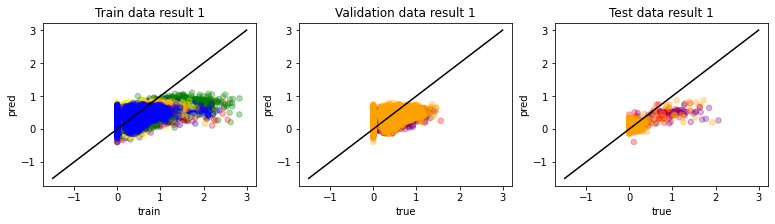

Epoch  26100 Train_loss:  0.2325524  Validation_loss:  0.20481434  Test_loss:  0.25302994
Epoch  26200 Train_loss:  0.23252513  Validation_loss:  0.20479959  Test_loss:  0.2530229
Epoch  26300 Train_loss:  0.2325159  Validation_loss:  0.2048137  Test_loss:  0.2529648
Epoch  26400 Train_loss:  0.2325046  Validation_loss:  0.20481832  Test_loss:  0.25294104
Epoch  26500 Train_loss:  0.23252052  Validation_loss:  0.20487568  Test_loss:  0.25282717
Epoch  26600 Train_loss:  0.23249401  Validation_loss:  0.20480853  Test_loss:  0.25291806
Epoch  26700 Train_loss:  0.23247577  Validation_loss:  0.20481439  Test_loss:  0.2528599
Epoch  26800 Train_loss:  0.23246184  Validation_loss:  0.20485675  Test_loss:  0.25272444
Epoch  26900 Train_loss:  0.23246126  Validation_loss:  0.20482925  Test_loss:  0.25275186
Epoch  27000 Train_loss:  0.23244357  Validation_loss:  0.20478863  Test_loss:  0.25280046
Epoch  27100 Train_loss:  0.23245701  Validation_loss:  0.20484225  Test_loss:  0.25268358
Epoch 

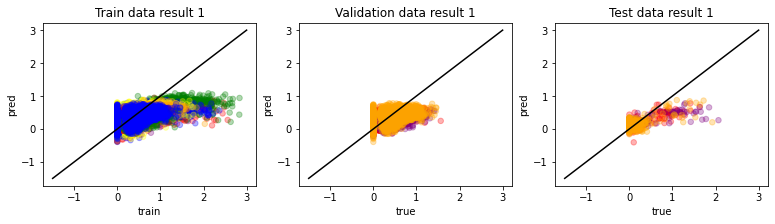

Epoch  28100 Train_loss:  0.23238978  Validation_loss:  0.20484729  Test_loss:  0.25255868
Epoch  28200 Train_loss:  0.23235567  Validation_loss:  0.20477936  Test_loss:  0.25266156
Epoch  28300 Train_loss:  0.23238076  Validation_loss:  0.20485535  Test_loss:  0.25253567
Epoch  28400 Train_loss:  0.23238312  Validation_loss:  0.2048562  Test_loss:  0.25254366
Epoch  28500 Train_loss:  0.23238212  Validation_loss:  0.20492607  Test_loss:  0.25241432
Epoch  28600 Train_loss:  0.23233704  Validation_loss:  0.20481198  Test_loss:  0.2525786
Epoch  28700 Train_loss:  0.23234867  Validation_loss:  0.20491478  Test_loss:  0.25240752
Epoch  28800 Train_loss:  0.23233402  Validation_loss:  0.20482479  Test_loss:  0.2525626
Epoch  28900 Train_loss:  0.23233803  Validation_loss:  0.20488389  Test_loss:  0.25245586
Epoch  29000 Train_loss:  0.2323138  Validation_loss:  0.2048306  Test_loss:  0.25253135
Epoch  29100 Train_loss:  0.23232076  Validation_loss:  0.20485249  Test_loss:  0.25249422
Epoc

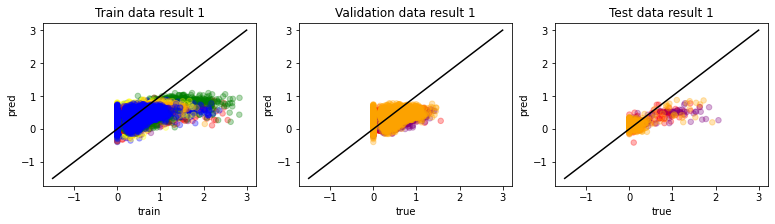

Epoch  30100 Train_loss:  0.23230106  Validation_loss:  0.20492615  Test_loss:  0.2523596
Epoch  30200 Train_loss:  0.23225966  Validation_loss:  0.20480427  Test_loss:  0.25256035
Epoch  30300 Train_loss:  0.23230134  Validation_loss:  0.20496309  Test_loss:  0.25230286
Epoch  30400 Train_loss:  0.23228791  Validation_loss:  0.2049364  Test_loss:  0.25232852
Epoch  30500 Train_loss:  0.23227671  Validation_loss:  0.2048961  Test_loss:  0.25240484
Epoch  30600 Train_loss:  0.23227794  Validation_loss:  0.20490779  Test_loss:  0.2523953
Epoch  30700 Train_loss:  0.23227164  Validation_loss:  0.20491722  Test_loss:  0.25236765
Epoch  30800 Train_loss:  0.23225729  Validation_loss:  0.2048734  Test_loss:  0.2524253
Epoch  30900 Train_loss:  0.23227198  Validation_loss:  0.20494051  Test_loss:  0.2523231
Epoch  31000 Train_loss:  0.23227361  Validation_loss:  0.20492522  Test_loss:  0.25236836
Epoch  31100 Train_loss:  0.23226877  Validation_loss:  0.20492753  Test_loss:  0.25234953
Epoch 

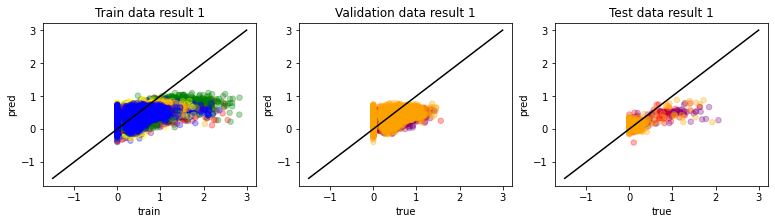

Epoch  32100 Train_loss:  0.23223229  Validation_loss:  0.20495075  Test_loss:  0.2523058
Epoch  32200 Train_loss:  0.23223102  Validation_loss:  0.20492202  Test_loss:  0.2523471
Epoch  32300 Train_loss:  0.23224925  Validation_loss:  0.20500247  Test_loss:  0.25221384
Epoch  32400 Train_loss:  0.23221849  Validation_loss:  0.20496608  Test_loss:  0.25224292
Epoch  32500 Train_loss:  0.2322322  Validation_loss:  0.20494342  Test_loss:  0.25230414
Epoch  32600 Train_loss:  0.23222686  Validation_loss:  0.20495623  Test_loss:  0.2522889
Epoch  32700 Train_loss:  0.23220249  Validation_loss:  0.2049183  Test_loss:  0.25233588
Epoch  32800 Train_loss:  0.23220614  Validation_loss:  0.20495644  Test_loss:  0.25228465
Epoch  32900 Train_loss:  0.23219709  Validation_loss:  0.20492437  Test_loss:  0.25232637
Epoch  33000 Train_loss:  0.23219948  Validation_loss:  0.2049231  Test_loss:  0.25233054
Epoch  33100 Train_loss:  0.2322094  Validation_loss:  0.20494658  Test_loss:  0.25228116
Epoch 

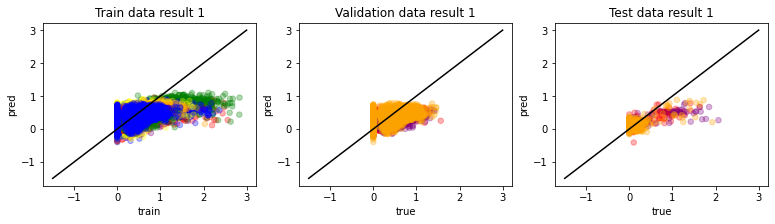

Epoch  34100 Train_loss:  0.23220296  Validation_loss:  0.20499463  Test_loss:  0.25222504
Epoch  34200 Train_loss:  0.2321993  Validation_loss:  0.20500995  Test_loss:  0.25215897
Epoch  34300 Train_loss:  0.23217687  Validation_loss:  0.20496245  Test_loss:  0.2522215
Epoch  34400 Train_loss:  0.23217164  Validation_loss:  0.20497292  Test_loss:  0.252218
Epoch  34500 Train_loss:  0.23220143  Validation_loss:  0.20498678  Test_loss:  0.25221524
Epoch  34600 Train_loss:  0.23215735  Validation_loss:  0.20492679  Test_loss:  0.25228438
Epoch  34700 Train_loss:  0.23218612  Validation_loss:  0.20499726  Test_loss:  0.25218537
Epoch  34800 Train_loss:  0.232156  Validation_loss:  0.20491596  Test_loss:  0.25230247
Epoch  34900 Train_loss:  0.23219046  Validation_loss:  0.20502087  Test_loss:  0.2521257
Epoch  35000 Train_loss:  0.23215926  Validation_loss:  0.20498355  Test_loss:  0.25219408
Epoch  35100 Train_loss:  0.23215236  Validation_loss:  0.20495516  Test_loss:  0.25225583
Epoch 

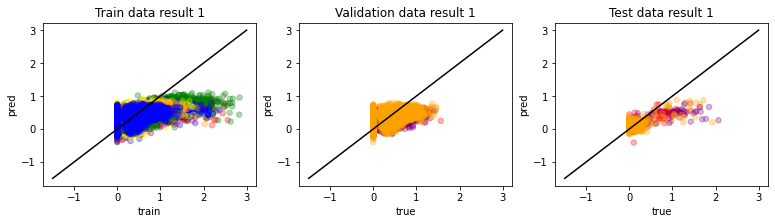

Epoch  36100 Train_loss:  0.23213716  Validation_loss:  0.2049836  Test_loss:  0.25221336
Epoch  36200 Train_loss:  0.23215379  Validation_loss:  0.2050064  Test_loss:  0.25218305
Epoch  36300 Train_loss:  0.23214181  Validation_loss:  0.20496759  Test_loss:  0.25224686
Epoch  36400 Train_loss:  0.2321311  Validation_loss:  0.20498006  Test_loss:  0.2522212
Epoch  36500 Train_loss:  0.23217037  Validation_loss:  0.20501061  Test_loss:  0.25220263
Epoch  36600 Train_loss:  0.2321725  Validation_loss:  0.20497985  Test_loss:  0.25224525
Epoch  36700 Train_loss:  0.2321726  Validation_loss:  0.20504062  Test_loss:  0.25213724
Epoch  36800 Train_loss:  0.23212765  Validation_loss:  0.2049549  Test_loss:  0.25226313
Epoch  36900 Train_loss:  0.23215191  Validation_loss:  0.20497057  Test_loss:  0.2522568
Epoch  37000 Train_loss:  0.23216493  Validation_loss:  0.20502411  Test_loss:  0.2521662
Epoch  37100 Train_loss:  0.23215379  Validation_loss:  0.20499137  Test_loss:  0.25221753
Epoch  3

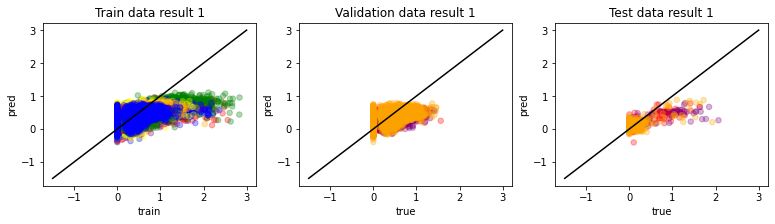

Epoch  38100 Train_loss:  0.23211646  Validation_loss:  0.20498066  Test_loss:  0.25220692
Epoch  38200 Train_loss:  0.23214756  Validation_loss:  0.20506662  Test_loss:  0.2520771
Epoch  38300 Train_loss:  0.23212864  Validation_loss:  0.20501436  Test_loss:  0.2521597
Epoch  38400 Train_loss:  0.23215851  Validation_loss:  0.20510238  Test_loss:  0.25201863
Epoch  38500 Train_loss:  0.23216131  Validation_loss:  0.2050749  Test_loss:  0.2520626
Epoch  38600 Train_loss:  0.2321648  Validation_loss:  0.20509283  Test_loss:  0.25205547
Epoch  38700 Train_loss:  0.23214725  Validation_loss:  0.20509619  Test_loss:  0.2520079
Epoch  38800 Train_loss:  0.23212458  Validation_loss:  0.20504989  Test_loss:  0.25209147
Epoch  38900 Train_loss:  0.23213148  Validation_loss:  0.20504516  Test_loss:  0.25209162
Epoch  39000 Train_loss:  0.2321761  Validation_loss:  0.20513478  Test_loss:  0.25197932
Epoch  39100 Train_loss:  0.23215106  Validation_loss:  0.2050929  Test_loss:  0.25202945
Epoch  

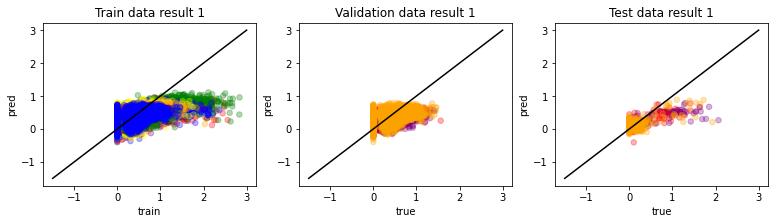

Epoch  40100 Train_loss:  0.23207955  Validation_loss:  0.20494787  Test_loss:  0.25224695
Epoch  40200 Train_loss:  0.23210235  Validation_loss:  0.20501259  Test_loss:  0.2521519
Epoch  40300 Train_loss:  0.23212358  Validation_loss:  0.20506065  Test_loss:  0.25208846
Epoch  40400 Train_loss:  0.23210104  Validation_loss:  0.2050362  Test_loss:  0.252105
Epoch  40500 Train_loss:  0.23211046  Validation_loss:  0.2050525  Test_loss:  0.25209185
Epoch  40600 Train_loss:  0.23213552  Validation_loss:  0.20510305  Test_loss:  0.25202426
Epoch  40700 Train_loss:  0.2321354  Validation_loss:  0.20508648  Test_loss:  0.25205645
Epoch  40800 Train_loss:  0.23213027  Validation_loss:  0.20509353  Test_loss:  0.25206244
Epoch  40900 Train_loss:  0.23212412  Validation_loss:  0.20506579  Test_loss:  0.2520876
Epoch  41000 Train_loss:  0.23213036  Validation_loss:  0.20508778  Test_loss:  0.2520484
Epoch  41100 Train_loss:  0.23214582  Validation_loss:  0.20513628  Test_loss:  0.25199157
Epoch  

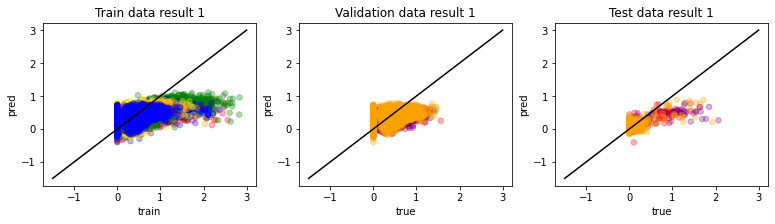

Epoch  42100 Train_loss:  0.23211886  Validation_loss:  0.20510353  Test_loss:  0.25201803
Epoch  42200 Train_loss:  0.23209767  Validation_loss:  0.20507124  Test_loss:  0.25205287
Epoch  42300 Train_loss:  0.23212978  Validation_loss:  0.20511568  Test_loss:  0.2520295
Epoch  42400 Train_loss:  0.23213096  Validation_loss:  0.20512994  Test_loss:  0.25198784
Epoch  42500 Train_loss:  0.2320941  Validation_loss:  0.20503928  Test_loss:  0.25212625
Epoch  42600 Train_loss:  0.23209675  Validation_loss:  0.20507127  Test_loss:  0.25207847
Epoch  42700 Train_loss:  0.23213907  Validation_loss:  0.20513539  Test_loss:  0.25199574
Epoch  42800 Train_loss:  0.23207815  Validation_loss:  0.20500702  Test_loss:  0.25216872
Epoch  42900 Train_loss:  0.23217088  Validation_loss:  0.20518462  Test_loss:  0.2519592
Epoch  43000 Train_loss:  0.23211811  Validation_loss:  0.20512664  Test_loss:  0.25199768
Epoch  43100 Train_loss:  0.23217383  Validation_loss:  0.20518334  Test_loss:  0.2519653
Epo

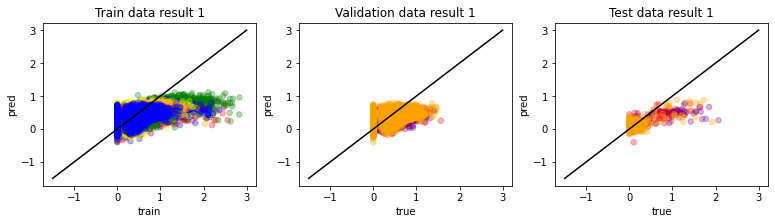

Epoch  44100 Train_loss:  0.23210965  Validation_loss:  0.20510656  Test_loss:  0.25205618
Epoch  44200 Train_loss:  0.23212585  Validation_loss:  0.20515472  Test_loss:  0.2519809
Epoch  44300 Train_loss:  0.23215769  Validation_loss:  0.2051711  Test_loss:  0.25197276
Epoch  44400 Train_loss:  0.23212832  Validation_loss:  0.20515817  Test_loss:  0.25196025
Epoch  44500 Train_loss:  0.23213296  Validation_loss:  0.20516716  Test_loss:  0.25197357
Epoch  44600 Train_loss:  0.2321158  Validation_loss:  0.20515983  Test_loss:  0.2519623
Epoch  44700 Train_loss:  0.2321071  Validation_loss:  0.20509724  Test_loss:  0.25207305
Epoch  44800 Train_loss:  0.23210166  Validation_loss:  0.20514306  Test_loss:  0.2519767
Epoch  44900 Train_loss:  0.23215042  Validation_loss:  0.2052069  Test_loss:  0.25192174
Epoch  45000 Train_loss:  0.23211381  Validation_loss:  0.20516492  Test_loss:  0.25196102
Epoch  45100 Train_loss:  0.23213547  Validation_loss:  0.20518076  Test_loss:  0.25194395
Epoch 

In [ ]:
num_epochs = 50000
learning_rate = 0.0001
loss_fn = F.mse_loss
batch_size = 5000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = CNN_model()
model.load_state_dict(torch.load(PATH))
model = model.to(device)

opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

In [ ]:
num_epochs = 20000
learning_rate = 0.0005
loss_fn = F.mse_loss
batch_size = 5000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = CNN_model()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)